# BTAlert-AI

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

## Análise dos dados coletados da aplicação

In [2]:
df_all_samples = pd.read_csv('data/samples.csv', delimiter=';', index_col='timestamp')
df_last_samples = df_all_samples.tail(185)
df_all_samples

,req_failed,request_per_sec,cpu_percent,memory_percent,lock_count,system_health
timestamp,,,,,,
1652266207,0.0000,0.00,0.000286,0.681229,1.0,1.0000
1652266222,0.0000,0.80,0.022767,0.740280,1.0,1.0000
1652266237,0.0000,12.07,0.065587,0.783585,1.0,1.0000
1652266252,0.0000,15.27,0.116834,0.881149,1.0,1.0000
1652266267,0.0000,20.93,0.172781,0.863525,2.0,1.0000
...,...,...,...,...,...,...
1652276332,0.0559,78.73,0.842445,0.918015,1.0,0.9441
1652276347,0.0736,82.40,0.825548,0.919022,1.0,0.9264
1652276362,0.0024,83.20,0.868229,0.919525,1.0,0.9976


## Dicionário de dados

In [3]:
df_samples_data_dict = pd.read_csv('data/samples_data_dict.csv', delimiter=';', index_col='column', dtype=str)
df_samples_data_dict

,type,range,example,description
column,,,,
timestamp,int64,"[0,+Inf]",1652266207,timestamp when metrics were collected
req_failed,float64,"[0,1]",0.53,percentage of requests that failed
request_per_sec,float64,"[0,+Inf]",32.25,requests per second sent to the server
lock_count,float64,"[0,+Inf]",3.0,number of locks in the database
cpu_percent,float64,"[0,1]",0.95,cpu percentage spent
memory_percent,float64,"[0,1]",0.84,memory percentage spent
system_health,float64,"[0,1]",0.25,server's ability to respond to requests correctly


## Matriz de correlação das métricas

<AxesSubplot:>

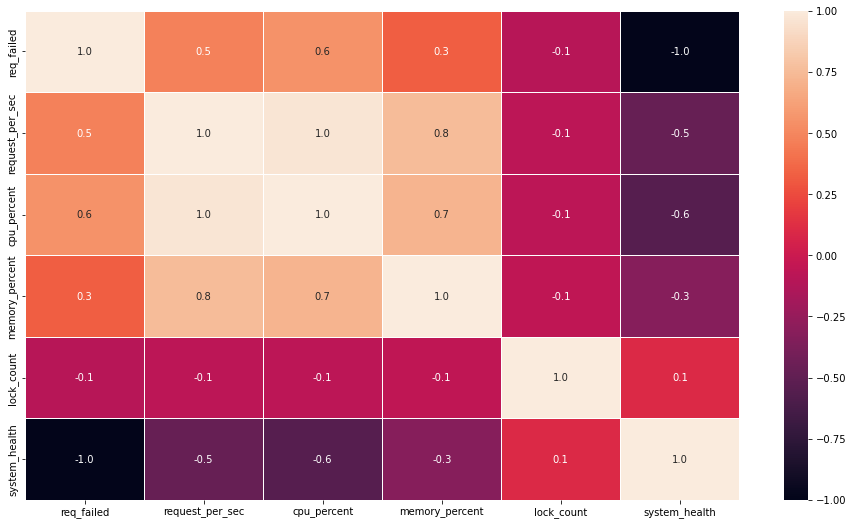

In [4]:
_, ax = plt.subplots(figsize=(16, 9))
sn.heatmap(df_last_samples.corr(), annot=True, fmt='0.1f', linewidths=.6, ax=ax)

A matriz de correlação diz qual a influência que uma métrica tem em cima de outra. Correlações positivas nos diz que quando uma aumenta, a outra tende a aumentar também, e a negativa diz que quando uma diminui, a outra aumenta.  
Para o presente trabalho, estamos utilizando apenas os últimos 185 dados, pois há grandes lacunas nas quais o sistema estava indisponível por muito tempo, no qual não foi reiniciado, e isso atrapalharia tanto a correlação, quanto o modelo de IA, por isso a necessidade de filtrar esses dados.

## Análise das métricas de cpu, memória e saúde do sistema

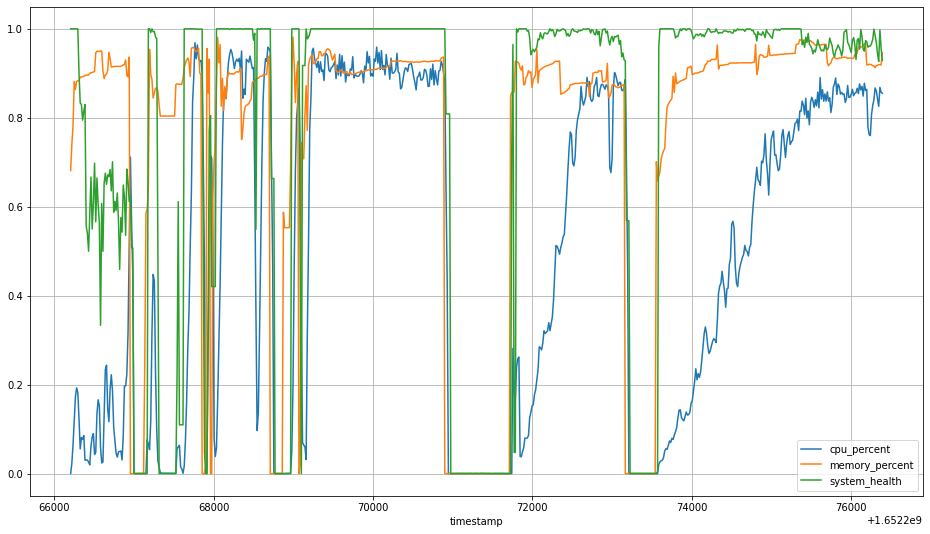

In [5]:
_, ax = plt.subplots(figsize=(16, 9))
df_all_samples.drop(['request_per_sec', 'lock_count', 'req_failed'], axis=1).plot(ax=ax)
ax.grid()
ax.legend()


O gráfico acima mostra o uso de CPU, memória RAM e a saúde do sistema em porcentagem.  
É possível perceber que conforme o uso de memória RAM e CPU aumentam, a saúde do sistema começa a cair, ficando instável. E caso a memória esteja em 0%, a saúde do sistema e o uso de CPU também ficam em 0%, pois é quando o sistema está totalmente indisponível.

## Análise das métricas de requisições por segundo, cpu, memória e saúde do sistema momentos antes da aplicação ficar indisponível

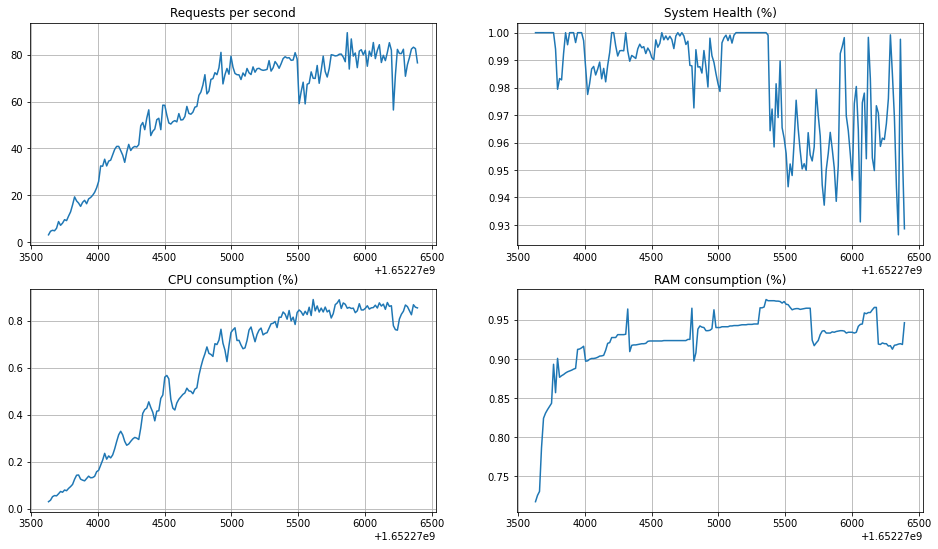

In [6]:
plot_data = (
    (
        ('Requests per second', df_last_samples.request_per_sec),
        ('System Health (%)', df_last_samples.system_health)
    ),
    (
        ('CPU consumption (%)', df_last_samples.cpu_percent),
        ('RAM consumption (%)', df_last_samples.memory_percent)
    )
)

_, ax = plt.subplots(len(plot_data), len(plot_data[0]), figsize=(16, 9))
for i, tup in enumerate(plot_data):
    for j, value in enumerate(tup):
        ax[i][j].set_title(value[0])
        ax[i][j].plot(value[1])
        ax[i][j].grid()

Os gráficos acima mostram a quantidade de requisições por segundo e a saúde do sistema, consumo de CPU e de memória RAM em porcentagem.  
É possível perceber também que, conforme o uso dos recursos aumentam, a saúde do sistema fica instável, uma vez que está chegando na sua faixa de exaustão, que é por volta de 80%+ do uso dos recursos.

# Previsão com LSTM